In [138]:
# Part 1: Iris Classification

# Getting the Dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import torch

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


In [139]:
# Visualize the Data
df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


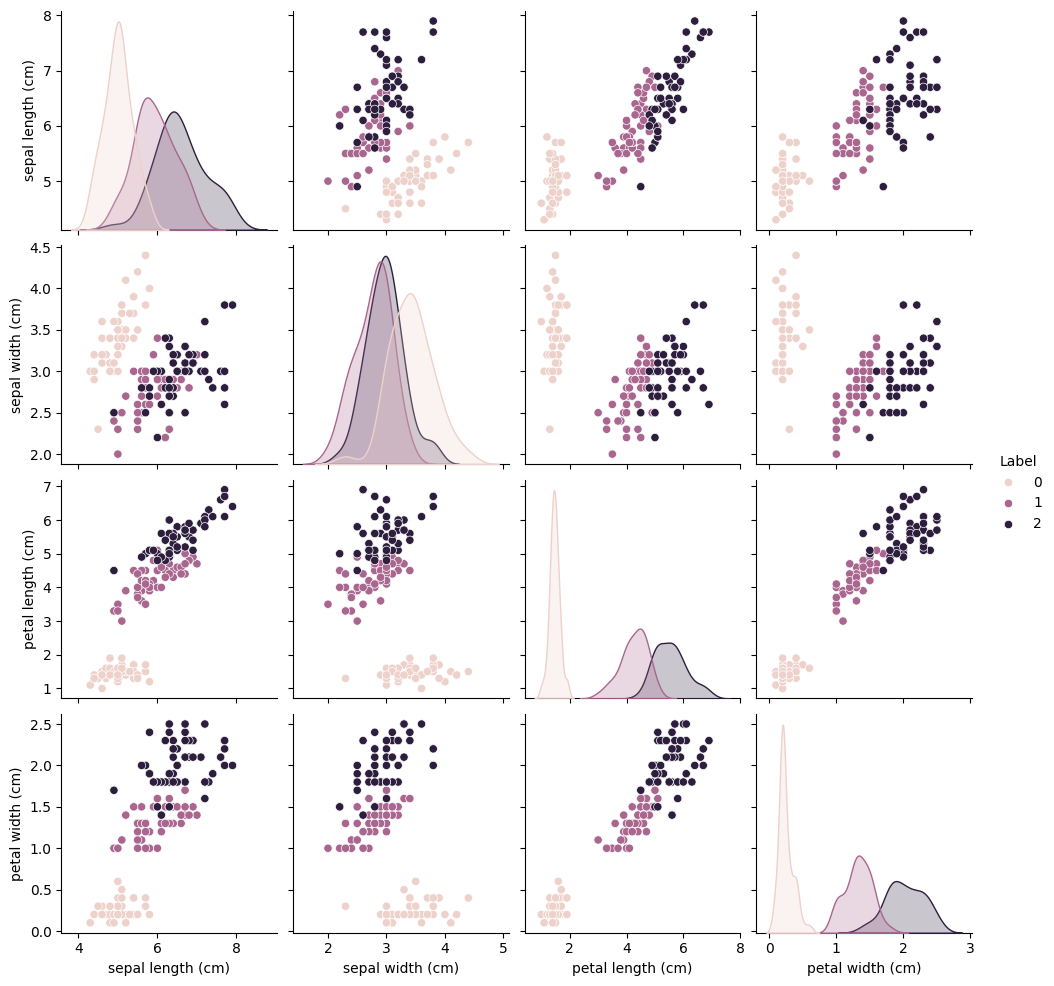

In [140]:
sns.pairplot(df,hue='Label')

In [141]:
# Code to normalize and encode the data
features_n = sklearn.preprocessing.normalize(features, return_norm=False)
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]


In [142]:
# Split the data
features_train, features_test, labels_train, labels_test = sklearn.model_selection.train_test_split(features_n,labels_onehot)

In [143]:
# Define the network

class MyNet(torch.nn.Module):   # inherited from torch.nn.Module
    def __init__(self,hidden_size=30,func=torch.nn.ReLU()):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_size,dtype=float)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_size,3,dtype=float)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return torch.Tensor(x)  # Make sure x is a tensor

net = MyNet(func=torch.nn.ReLU())
print(net)


MyNet(
  (fc1): Linear(in_features=4, out_features=30, bias=True)
  (func): ReLU()
  (fc2): Linear(in_features=30, out_features=3, bias=True)
)


In [144]:
num_classes = 3

dataset = torch.utils.data.TensorDataset(torch.tensor(features_train),torch.tensor(labels_train,dtype=torch.float64))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)

list(dataloader)[0]

[tensor([[0.7658, 0.6038, 0.2209, 0.0147],
         [0.7158, 0.3443, 0.5799, 0.1812],
         [0.7695, 0.3560, 0.5053, 0.1608],
         [0.8038, 0.5516, 0.2206, 0.0315],
         [0.8270, 0.5263, 0.1955, 0.0301],
         [0.6942, 0.3037, 0.6074, 0.2386],
         [0.7172, 0.3164, 0.5801, 0.2215],
         [0.7153, 0.3179, 0.5961, 0.1788],
         [0.8022, 0.5455, 0.2407, 0.0321],
         [0.8021, 0.5469, 0.2370, 0.0365],
         [0.8064, 0.5315, 0.2566, 0.0367],
         [0.8112, 0.5595, 0.1678, 0.0280],
         [0.7859, 0.5702, 0.2312, 0.0616],
         [0.7056, 0.3272, 0.5829, 0.2352],
         [0.7910, 0.5695, 0.2215, 0.0316],
         [0.6980, 0.3381, 0.5999, 0.1963]], dtype=torch.float64),
 tensor([[1., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1.,

In [145]:
# Train the network

def train(net, dataloader, val_x, val_lab, epochs=10, lr=0.05):

    epoch_data = []
    optim = torch.optim.Adam(net.parameters(), lr=lr)

    for ep in range(epochs):
        for (x, y) in dataloader:
            optim.zero_grad()
            z = net(x)
            loss = torch.nn.functional.cross_entropy(z, y) 
            loss.backward()
            optim.step()

        # Calculate validation accuracy
        with torch.no_grad():
            predictions = net(val_x)
           
            val_acc = calculate_accuracy(predictions, val_lab)
        
        epoch_data.append([loss,val_acc])
        print(f"Epoch {ep}: last batch loss = {loss}, val acc = {val_acc}")

    return epoch_data


In [146]:
def calculate_accuracy(predictions,val_lab):
    count = 0.0
    for i in range(predictions.size()[0]):
        predict = predictions[i].argmax()
        if (predict == val_lab[i].argmax()):
            count += 1
    return count/predictions.size()[0]

In [147]:
feat_tensor = torch.tensor(features_test)
lab_tensor = torch.tensor(labels_test)

loss_acc=train(net,dataloader,feat_tensor,lab_tensor,lr=0.05)


Epoch 0: last batch loss = 0.9656730032319373, val acc = 0.5263157894736842
Epoch 1: last batch loss = 0.7078387322273704, val acc = 0.5263157894736842
Epoch 2: last batch loss = 0.5157498268169631, val acc = 0.6842105263157895
Epoch 3: last batch loss = 0.39487429153997655, val acc = 0.9736842105263158
Epoch 4: last batch loss = 0.35835067457511066, val acc = 0.9736842105263158
Epoch 5: last batch loss = 0.31554670410907093, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.2706363602978632, val acc = 0.9736842105263158
Epoch 7: last batch loss = 0.2391327710670114, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.2197893425604724, val acc = 0.9736842105263158
Epoch 9: last batch loss = 0.2063265270377473, val acc = 0.9736842105263158


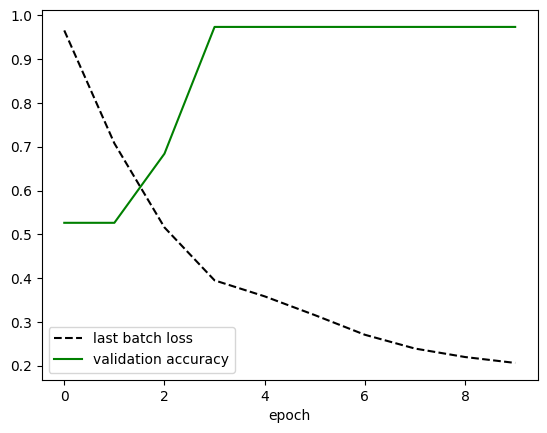

In [148]:
# Visualize train/validation accuracy graph

def plot_training_loss_acc(loss_acc):
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('epoch')
    ax.legend(ax.lines, ['last batch loss', 'validation accuracy'], loc='upper center', ncol = 2)

    loss_list=[]
    acc_list=[]
    for epoch in loss_acc:
        try:
            loss_list.append(epoch[0].detach_())
        except AttributeError:
            loss_list.append(epoch[0])
        try:
            acc_list.append(epoch[1].detach_())
        except AttributeError:
            acc_list.append(epoch[1]) 

    ax.plot(range(len(loss_acc)), loss_list, 'k--', label='last batch loss')
    ax.plot(range(len(loss_acc)), acc_list, 'g-', label='validation accuracy')

    plt.legend()
    plt.show()
    
plot_training_loss_acc(loss_acc)

Epoch 0: last batch loss = 1.1419627435826807, val acc = 0.23684210526315788
Epoch 1: last batch loss = 1.0930089618522207, val acc = 0.23684210526315788
Epoch 2: last batch loss = 1.0081254994267916, val acc = 0.5263157894736842
Epoch 3: last batch loss = 0.9485283725857098, val acc = 0.5263157894736842
Epoch 4: last batch loss = 0.9089136961297715, val acc = 0.5263157894736842
Epoch 5: last batch loss = 0.8748304924684974, val acc = 0.5263157894736842
Epoch 6: last batch loss = 0.837518153150603, val acc = 0.5263157894736842
Epoch 7: last batch loss = 0.8009942306654468, val acc = 0.5263157894736842
Epoch 8: last batch loss = 0.7712918616587874, val acc = 0.5263157894736842
Epoch 9: last batch loss = 0.7477588356055785, val acc = 0.5263157894736842


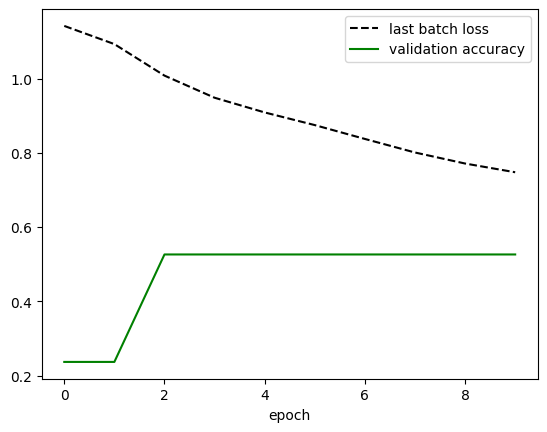

In [149]:
# Experiment

# One-layer network with 3 neurons (equal to the number of classes) 

class MyNet1(torch.nn.Module):   # inherited from torch.nn.Module
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,3,dtype=float)

    def forward(self,x):
        x = self.fc1(x)
        return torch.Tensor(x)  # Make sure x is a tensor

net1 = MyNet1()

loss_acc1=train(net1,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc1)

Epoch 0: last batch loss = 1.1485299762647407, val acc = 0.5
Epoch 1: last batch loss = 1.013247992286325, val acc = 0.5263157894736842
Epoch 2: last batch loss = 0.8515361394897561, val acc = 0.5263157894736842
Epoch 3: last batch loss = 0.6813552765524571, val acc = 0.5263157894736842
Epoch 4: last batch loss = 0.544610997247319, val acc = 0.5789473684210527
Epoch 5: last batch loss = 0.4417521952461067, val acc = 0.9473684210526315
Epoch 6: last batch loss = 0.4000208462654626, val acc = 0.9473684210526315
Epoch 7: last batch loss = 0.349471122051681, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.31900530650933817, val acc = 0.9736842105263158
Epoch 9: last batch loss = 0.2819137466698154, val acc = 0.9736842105263158


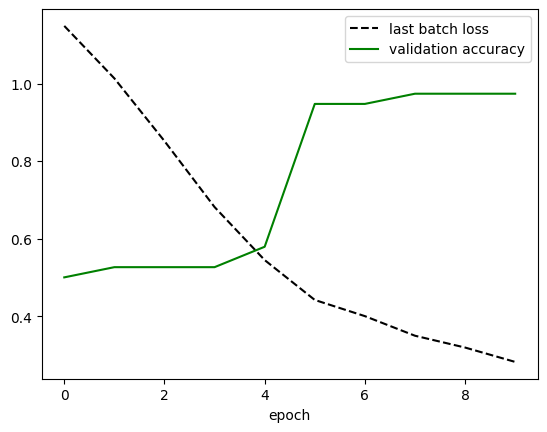

In [150]:
# Two-layer network with small/medium/large hidden layer

# small
net21 = MyNet(hidden_size=8,func=torch.nn.ReLU())

loss_acc21=train(net21,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc21)


Epoch 0: last batch loss = 1.0670419078374709, val acc = 0.23684210526315788
Epoch 1: last batch loss = 0.8601645093747478, val acc = 0.5526315789473685
Epoch 2: last batch loss = 0.6970708530442551, val acc = 0.5263157894736842
Epoch 3: last batch loss = 0.5405901645711496, val acc = 0.631578947368421
Epoch 4: last batch loss = 0.41969927992558526, val acc = 0.9473684210526315
Epoch 5: last batch loss = 0.3855357093243124, val acc = 0.9473684210526315
Epoch 6: last batch loss = 0.3371067298387654, val acc = 0.9473684210526315
Epoch 7: last batch loss = 0.28645571945229853, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.2567905744474105, val acc = 0.9736842105263158
Epoch 9: last batch loss = 0.23485167738562782, val acc = 0.9736842105263158


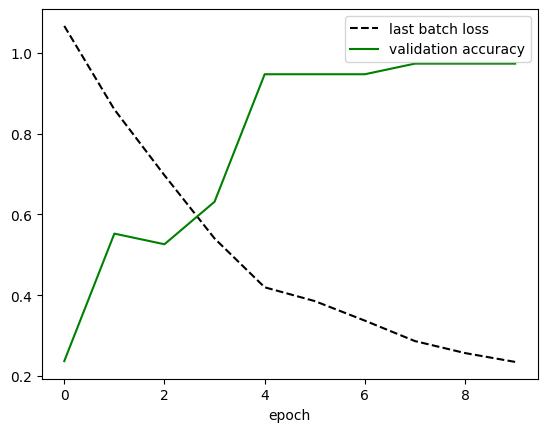

In [151]:
# medium
net22 = MyNet(hidden_size=32,func=torch.nn.ReLU())

loss_acc22=train(net22,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc22)

Epoch 0: last batch loss = 0.9189021996454441, val acc = 0.6842105263157895
Epoch 1: last batch loss = 0.6381680349995038, val acc = 0.5263157894736842
Epoch 2: last batch loss = 0.4852539852969618, val acc = 0.6842105263157895
Epoch 3: last batch loss = 0.38522952576885566, val acc = 0.9736842105263158
Epoch 4: last batch loss = 0.32879058049157656, val acc = 0.9736842105263158
Epoch 5: last batch loss = 0.2889902844057924, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.26151507187758866, val acc = 0.9736842105263158
Epoch 7: last batch loss = 0.24607382847840237, val acc = 0.9736842105263158
Epoch 8: last batch loss = 0.2391398174178417, val acc = 0.9736842105263158
Epoch 9: last batch loss = 0.22909371030451806, val acc = 0.9473684210526315


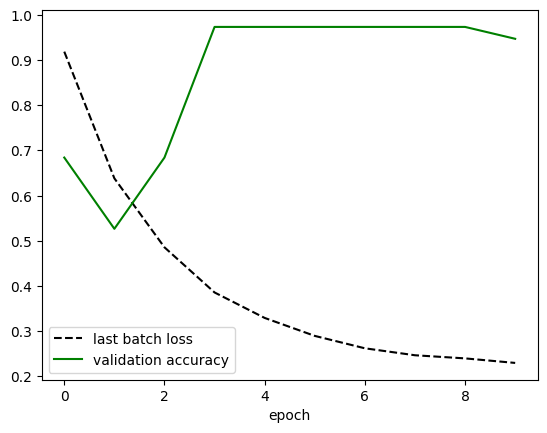

In [152]:
# large
net23 = MyNet(hidden_size=64,func=torch.nn.ReLU())

loss_acc23=train(net23,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc23)

Epoch 0: last batch loss = 0.9684448399674263, val acc = 0.7631578947368421
Epoch 1: last batch loss = 0.6461051161514785, val acc = 0.5789473684210527
Epoch 2: last batch loss = 0.5060361977841692, val acc = 0.9736842105263158
Epoch 3: last batch loss = 0.4140823763949341, val acc = 0.9473684210526315
Epoch 4: last batch loss = 0.14712728672646921, val acc = 0.9473684210526315
Epoch 5: last batch loss = 0.09965659264498977, val acc = 0.9736842105263158
Epoch 6: last batch loss = 0.3299548714212807, val acc = 0.9736842105263158
Epoch 7: last batch loss = 0.09870930964376004, val acc = 0.9473684210526315
Epoch 8: last batch loss = 0.1257290431244079, val acc = 0.9736842105263158
Epoch 9: last batch loss = 0.22306156639284666, val acc = 0.9736842105263158


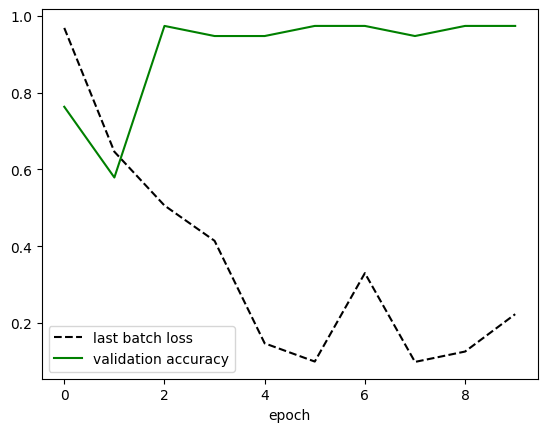

In [153]:
# Using more layers

class MyNet3(torch.nn.Module):   # inherited from torch.nn.Module
    def __init__(self,hidden_size1=15,hidden_size2=30,func1=torch.nn.ReLU(),func2=torch.nn.LeakyReLU(negative_slope=0.2)):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_size1,dtype=float)
        self.func1 = func1
        self.fc2 = torch.nn.Linear(hidden_size1,hidden_size2,dtype=float)
        self.func2 = func2  # Leaky ReLU
        self.fc3 = torch.nn.Linear(hidden_size2,3,dtype=float)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func1(x)
        x = self.fc2(x)
        x = self.func2(x)
        x = self.fc3(x)        
        return torch.Tensor(x)  # Make sure x is a tensor

net3 = MyNet3()

loss_acc3=train(net3,dataloader,feat_tensor,lab_tensor,lr=0.05)
plot_training_loss_acc(loss_acc3)
